In [0]:
!pip install yfinance

In [0]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

### Get a sample stock price from 2019-01-01 to today

In [0]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2019-01-01','2020-04-30')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800
2019-01-08,149.559998,151.820007,148.520004,150.750000,147.766861,41025300


### Extract the Close price column to plot

In [0]:
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any() # check for NaN

False

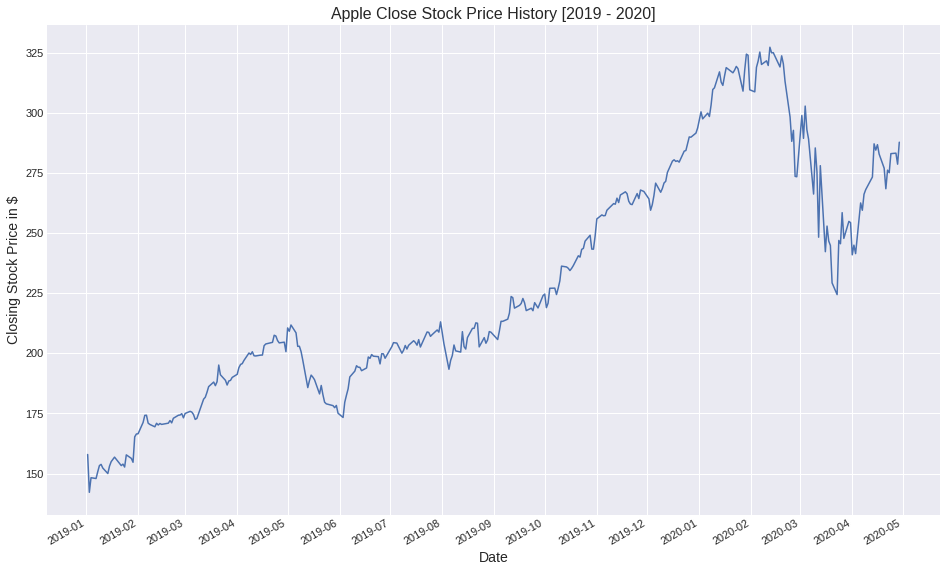

In [0]:
# Import matplotlib package for date plots

months = mdates.MonthLocator() # Get every year
dateFmt = mdates.DateFormatter('%Y-%m') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)

# Set figure title
plt.title('Apple Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Get stock of Apple, Google, Microsoft, Amazon, Facebook via Yahoo Finance

In [0]:
!mkdir data && touch close_price_big_5.csv

mkdir: cannot create directory ‘data’: File exists


In [0]:
def get_close_stock_price(codes, start_date='2010-01-01', end_date='2020-04-30'):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
df.to_csv('data/close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2012-05-18,75.768570,300.500488,29.270000,213.850006,38.230000
2012-05-21,80.182854,307.362366,29.750000,218.110001,34.029999
2012-05-22,79.567146,300.700714,29.760000,215.330002,31.000000
2012-05-23,81.508568,305.035034,29.110001,217.279999,32.000000
2012-05-24,80.760002,302.132141,29.070000,215.240005,33.029999


In [0]:
df.index

DatetimeIndex(['2012-05-18', '2012-05-21', '2012-05-22', '2012-05-23',
               '2012-05-24', '2012-05-25', '2012-05-29', '2012-05-30',
               '2012-05-31', '2012-06-01',
               ...
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29'],
              dtype='datetime64[ns]', name='Date', length=1999, freq=None)

In [0]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

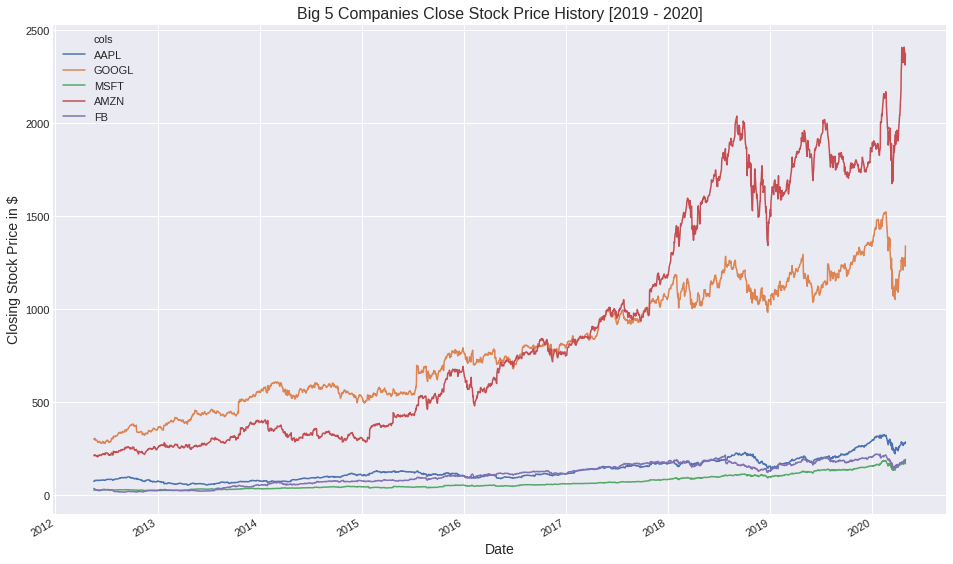

In [0]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Create X, y matrices for regression
Use history = number of days before prediction date

In [0]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        X.append( df.iloc[row_idx-history:row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X,y,dates = create_Xy(df, history=5)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

In [0]:
X.shape

(1994, 25)

In [0]:
y.shape

(1994, 5)

In [0]:
df.shape

(1999, 5)

### Create a Linear Regression Model to predict stock price

In [0]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
teacher_result = mean_squared_error(y_test, ypred)

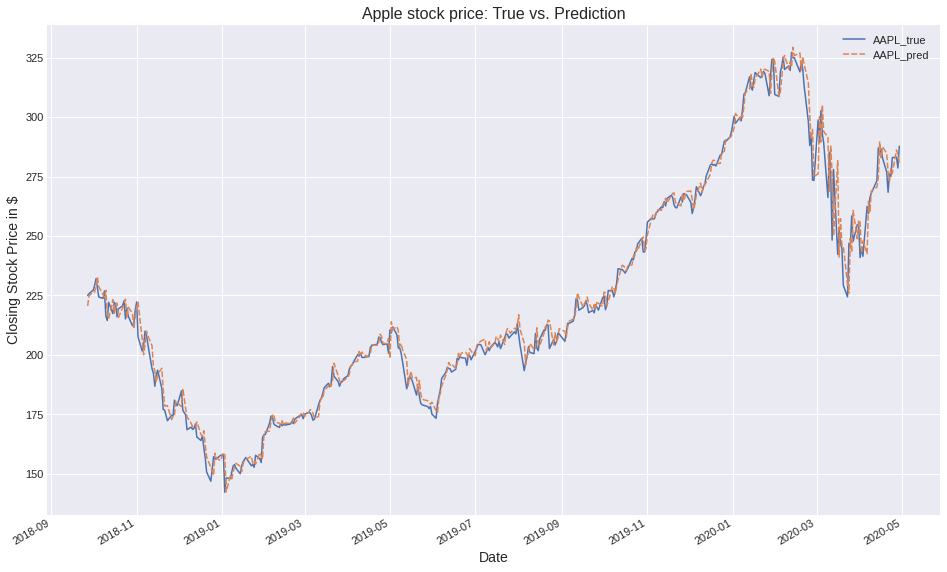

In [0]:
df_plot = pd.DataFrame({"AAPL_true": y_test[:,0], 'AAPL_pred': ypred[:,0]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Apple stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

# Exercise
1. Play with the above code to get familiar with stock price data and ways to create training data ( X = past stock price, y = future stock price )
2. Investigate if stock price of Big 5 companies are related to each other ( “FAAMG”—Facebook, Amazon, Apple, Microsoft, and Google )
3. Determine the features that could predict future stock price ( stock price from Yahoo Finance could be considered as raw features, create new features if needed )
4. Build a linear regression model to predict future stock price
5. Evaluate your model performance

## Sol Ex*.2*

*Investigate if stock price of Big 5 companies are related to each other ( “FAAMG”—Facebook, Amazon, Apple, Microsoft, and Google )*

In [0]:
ex2_df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
ex2_df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2012-05-18,75.768570,300.500488,29.270000,213.850006,38.230000
2012-05-21,80.182854,307.362366,29.750000,218.110001,34.029999
2012-05-22,79.567146,300.700714,29.760000,215.330002,31.000000
2012-05-23,81.508568,305.035034,29.110001,217.279999,32.000000
2012-05-24,80.760002,302.132141,29.070000,215.240005,33.029999


In [0]:
ex2_df.columns

Index(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'], dtype='object')

In [0]:
pearson_arr = np.zeros((5,5))

idx_i = 0

for i in ex2_df.columns:
  idx_j = 0
  for j in ex2_df.columns:
    pearson_arr[idx_i][idx_j] = ex2_df[i].corr(ex2_df[j])
    idx_j += 1
  
  idx_i += 1

pearson_arr

array([[1.        , 0.91609722, 0.96157005, 0.91883027, 0.87257799],
       [0.91609722, 1.        , 0.93846584, 0.95628114, 0.9702644 ],
       [0.96157005, 0.93846584, 1.        , 0.96288768, 0.87835746],
       [0.91883027, 0.95628114, 0.96288768, 1.        , 0.90654867],
       [0.87257799, 0.9702644 , 0.87835746, 0.90654867, 1.        ]])

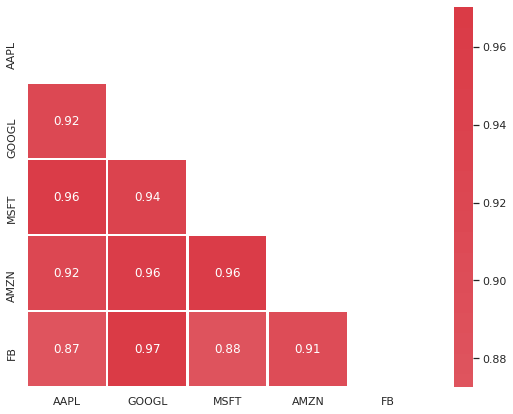

In [0]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pearson_arr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(pearson_arr, 
            mask=mask, 
            cmap=cmap, 
            center=.3, 
            xticklabels=ex2_df.columns, 
            yticklabels=ex2_df.columns, 
            annot=True, 
            linewidths=1.6)

In [0]:
variance_arr = np.zeros((len(ex2_df.columns), len(ex2_df["GOOGL"])))
idx_i = 0

for i in ex2_df.columns:
  for j in range(1, len(ex2_df[i])):
    variance_arr[idx_i][j] = ex2_df[i][j - 1] - ex2_df[i][j]
    # print(j)

  idx_i += 1

variance_arr.shape

(5, 1999)

In [0]:
variance_arr

array([[ 0.00000000e+00, -4.41428375e+00,  6.15707397e-01, ...,
        -2.00012207e-01,  4.59002686e+00, -9.15002441e+00],
       [ 0.00000000e+00, -6.86187744e+00,  6.66165161e+00, ...,
         5.73999023e+00,  3.82700195e+01, -1.09590088e+02],
       [ 0.00000000e+00, -4.79999542e-01, -1.00002289e-02, ...,
         5.00000000e-01,  4.24000549e+00, -7.61999512e+00],
       [ 0.00000000e+00, -4.25999451e+00,  2.77999878e+00, ...,
         3.42199707e+01,  6.19199219e+01, -5.86298828e+01],
       [ 0.00000000e+00,  4.20000076e+00,  3.02999878e+00, ...,
         2.57000732e+00,  4.58999634e+00, -1.12799988e+01]])

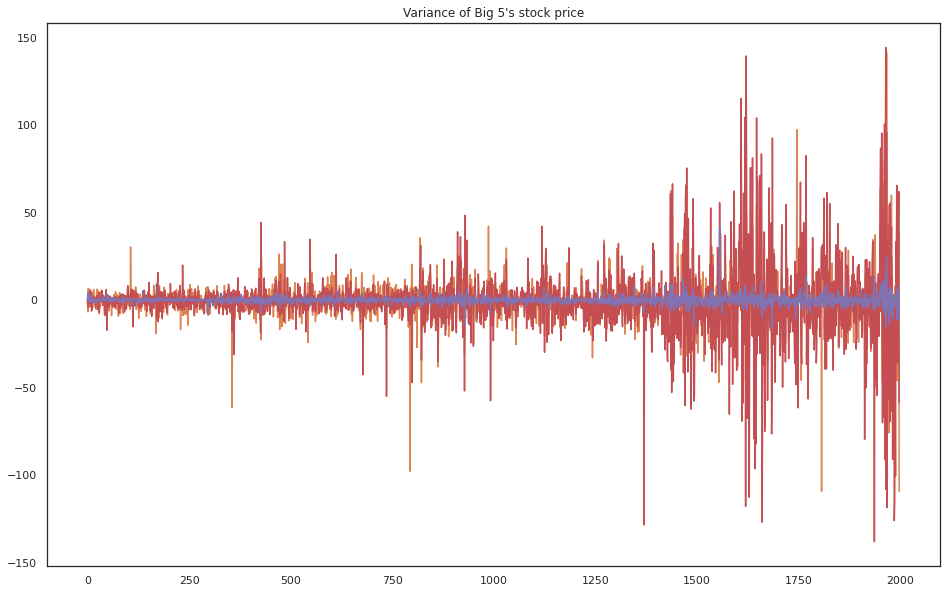

In [0]:
plt.title("Variance of Big 5's stock price")

for i in range(len(variance_arr)):
  plt.plot(variance_arr[i])

plt.show()

## Sol Ex.3, 4, 5

**Sử dụng MultiTaskLasso của Sklearn để lựa chọn feature**

In [0]:
from sklearn.linear_model import MultiTaskLasso

lasso = MultiTaskLasso(max_iter=10000).fit(X_train, y_train)

In [0]:
y_pred_new = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_new)

print(f'Teacher result: {teacher_result}\nCuston feature selection result: {lasso_mse}')

Teacher result: 472.59019834587855
Custon feature selection result: 477.5737823392632


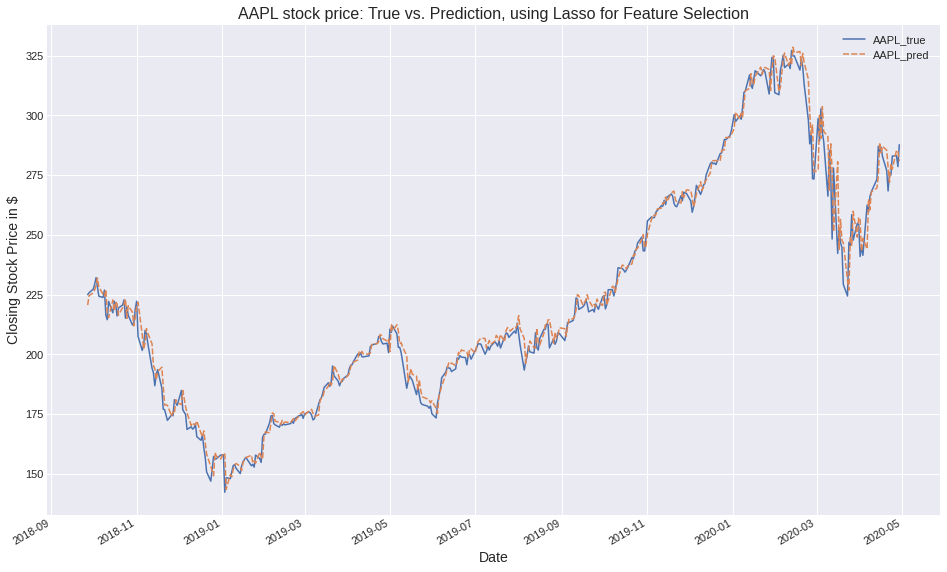

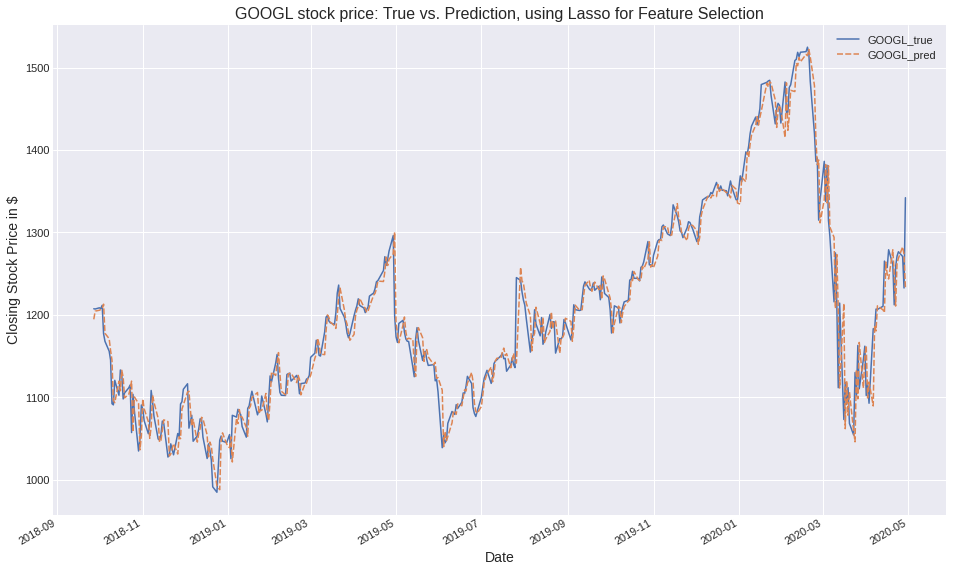

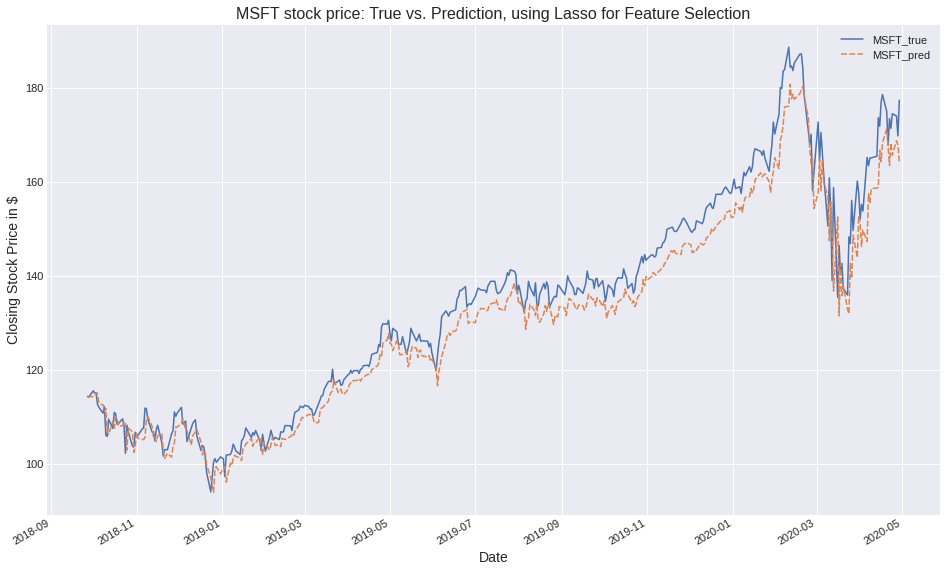

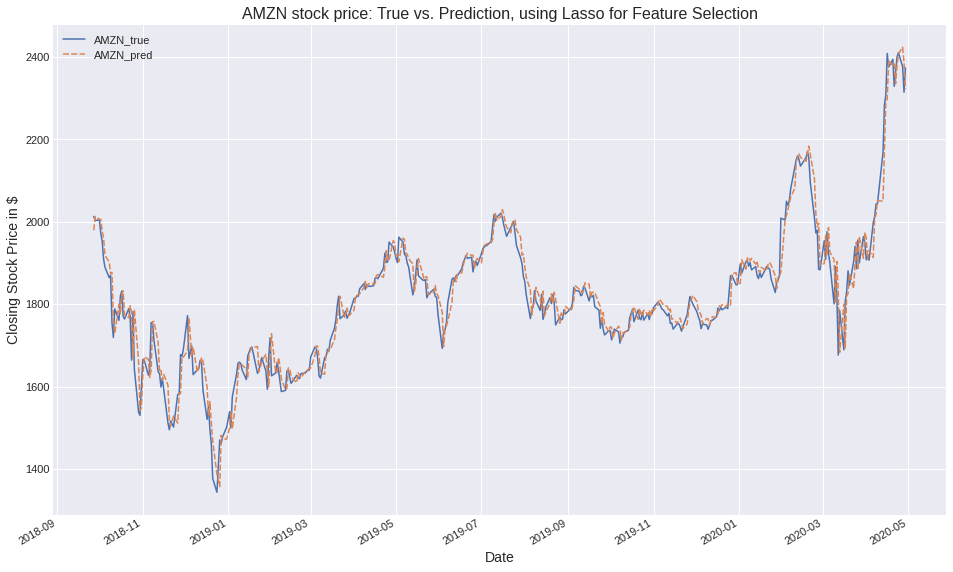

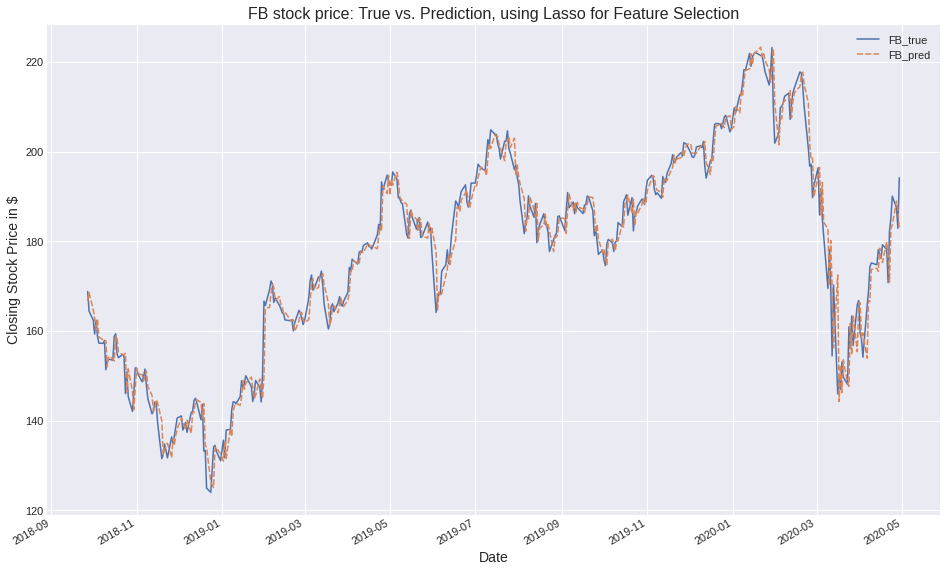

In [0]:
count = 0

for value in df.columns:
  df_plot = pd.DataFrame({f"{value}_true": y_test[:,count], f'{value}_pred': y_pred_new[:,count]}, index=dates_test)

  # Create subplots to plot graph and control axes
  fig, ax = plt.subplots(figsize=(16,10))
  sns.lineplot(data=df_plot)

  # Format the ticks
  loc = mdates.AutoDateLocator()
  ax.xaxis.set_major_locator(loc)
  ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

  # Set figure title
  plt.title(f'{value} stock price: True vs. Prediction, using Lasso for Feature Selection', fontsize=16)
  # Set x label
  plt.xlabel('Date', fontsize=14)
  # Set y label
  plt.ylabel('Closing Stock Price in $', fontsize=14)

  # Rotate and align the x labels
  fig.autofmt_xdate()

  # Show plot
  plt.show()

  count += 1

Sau khi áp dụng Lasso để lựa chọn feature cần thiết, mô hình sau khi huấn luyện cho ra kết quả kém hơn chút so với kết quả mẫu: 

**Mean Square Error: 477 (Lasso) vs 472 (Teacher)**

Trên thực tế khi so sánh predict và true của giá cổ phiếu 5 công ty:

- Giá dự đoán cổ phiếu APPL có xu hướng tăng nhẹ so với thực tế
- Giá dự đoán cổ phiếu GOOGL, AMZN, FB khá sát với giá thực tế
- Giá dự đoán cổ phiếu MSFT thì bị thấp hơn rõ rệt so với giá thực tế